# Assignment 3


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 5 students.*

* Aizhan Akhmetzhanova
* Tony Chen
* Lucas Makinen
* Emre Oezkan
* Sachin Smart

---

## Problem 1: Hubble goes GP

You will remember that Edwin Hubble produced the first observational evidence for the expansion of the universe by linear regression of velocities and distances of nearby galaxies. One main limitation with his analysis is the lack of error estimates for any of the observed quantities. In Assignment, we assumed that all observed distances have and unknown but *the same* error. Here we will use the flexibility of Gaussian Processes instead.

### Problem 1.1 (3pts):

Load the data file `hubble_corrected.txt`. It's a version of the data from Assignment 1, Problem 4, that applies several astronomically motivated corrections, but still comes without error estimates.

Perform GP regression of the relation $R(V)$ for noisy data with unknown variance from `scikit-learn` that we discussed during the lecture. Use `ConstantKernel * Matern` (a robust replacement of `RBF`) and `WhiteKernel` kernel functions. Plot the data, the regression mean and $\pm1\sigma$ confidence regions. Don't forget axis labels.

### Problem 1.1 Solution

As instructed in the exercise, we use a combination of the Constant kernel and the Matern kernel for the Gaussian process kernel and the WhiteKernel for the noise kernel. We fit the Gaussian Process for three different choices of the initial values for the kernel parameters. Ideally, we want to see convergence against the same set of kernel parameters for each of the choices for the initial values. 

Begin by loading the data.

In [3]:
###############################################################################
#Problem 1.1
###############################################################################

import numpy as np
import pandas as pd

###############################################
#Load data set
###############################################

data = pd.read_table("catalog.txt").iloc[:,0:2]
V = np.array(data.iloc[:,0])
R = np.array(data.iloc[:,1])
del(data)

In [4]:
V, R

(array([ -16.884707,   25.814468,   52.784249,    6.177834,  -35.519733,
         -69.594526,  397.904002,  409.449093,  434.157392,  310.307323,
         375.513335,   92.004747,  588.660797,  214.828359,  429.343347,
         819.277569,  591.815353,  735.358921,  613.147178, 1041.62637 ,
         521.526479,  839.773785,  806.459658, 1106.849401]),
 array([0.032, 0.034, 0.214, 0.063, 0.275, 0.275, 0.45 , 0.5  , 0.5  ,
        0.63 , 0.4  , 0.9  , 0.9  , 0.9  , 0.6  , 1.   , 1.1  , 1.1  ,
        1.4  , 1.7  , 1.   , 1.   , 1.   , 2.   ]))

Continue by defining the intial choices of the kernel parameter and for each choice, fit the Gaussian Process and plot the result.

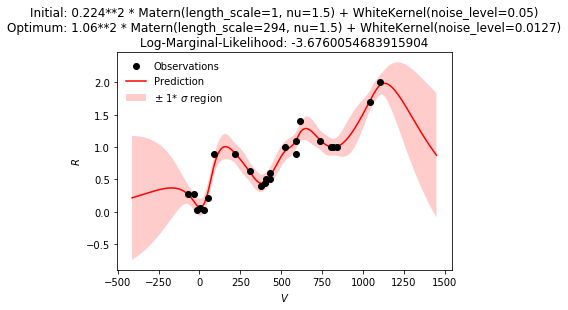

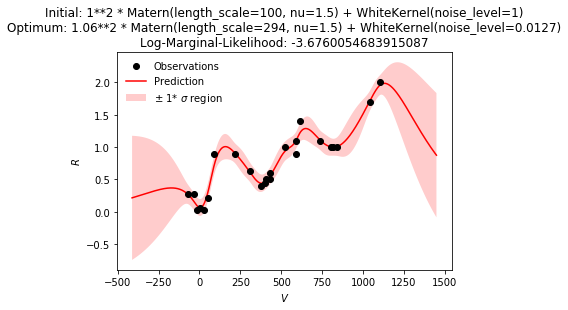

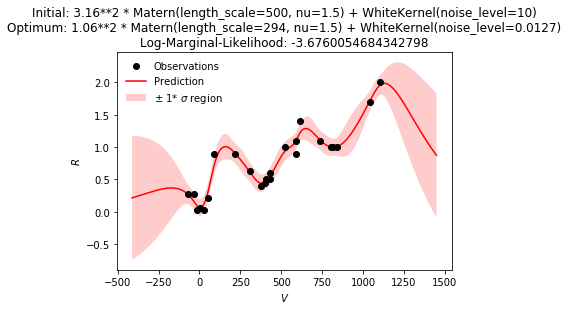

In [5]:
###############################################
#Fit a Gaussian process to the data
###############################################

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(1)

#initial guesses for kernel parameter
C_scale = [0.05, 1.0, 10.0]
M_scale = [1.0, 100.0, 500.0]
WK_scale = [0.05, 1.0, 10.0]

for i in range(len(C_scale)):
    #set up the kernel 
    kernel = C(C_scale[i], (1e-3, 1e3)) * Matern(length_scale=M_scale[i], length_scale_bounds=(1e-3, 1e3), nu=1.5) \
                + WhiteKernel(noise_level=WK_scale[i], noise_level_bounds=(1e-10, 1e+1))
    
    #fit the Gaussian process
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(V.reshape(-1,1), R)
    
    #define a V-space grid based on which the GP predictions will be made
    x = np.linspace(start=min(V)-np.std(V),stop = max(V)+np.std(V), num = 1000)
    
    #calculate the GP predictions on the V-space grid
    R_pred, sigma = gp.predict(x.reshape(-1,1), return_std=True)
    
    #plot 
    plt.figure()
    plt.plot(V, R, 'ko', zorder=10, label='Observations')
    plt.plot(x, R_pred, 'r-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([R_pred - 1.0 * sigma,
                            (R_pred + 1.0 * sigma)[::-1]]),
             alpha=.2, fc='r', ec='None', label='$ \pm$ 1* $\sigma$ region')
    plt.xlabel("$V$")
    plt.ylabel("$R$")
    plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
              % (kernel, gp.kernel_,
                 gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.legend(loc='upper left', frameon=False);
    plt.show()

We make the following observations:

* The optimal kernel parameters are similar for each of the three initial choices of kernel parameters. This indicates that (with reasonable doubt), the optimization process converges against the same set of kernel parameters, independent of the initial choices. This is very promising.
* The predictions by the fitted Gaussian Process look very reasonable. Particularly, most of the observations are contained in the $\pm 1 \sigma$ region, which corresponds to a confidence interval of approximately $67\%$. 

### Problem 1.2 (1pt):

The approach in 1.1 suffices to support Hubble's original finding that the universe is in fact expanding, but it is not satisfying for two reasons:

1. The GP mean function is not a straight line, in contrast to our (well: Hubble's) theoretical prejudice.
2. The variance of the data is assumed to be constant and uncorrelated: $\Sigma_{y,i}=\Sigma_y\ \forall i$.

Let's say that we are certain that the data model is linear without intercept. Then we can remedy both of these problems by specifying the analytic likelihood as a stochastic process with two sets of RVs:

$$
\begin{align}
y(x) &= b x + e(x)\\
e(x)&\sim\mathrm{GP}(\mu(x), \kappa(x,x'))
\end{align}
$$

That means we impose that data come from a linear model (with only a slope parameter and no intercept) and that the *residual errors* $e$ of the linear model come from a GP. That evidently addresses shortcoming 1, and it allows for a more flexible error model.

To visualize the approach, let's break it up into two steps.

1. Compute $e_i = R_i - \tilde{b}_{MLE} V_i$, where $\tilde{b}_{MLE}$ is the MLE of the ordinary linear regression. 
2. Perform GP regression of $e(V)$ with the same kernel as in 1.1.

### Problem 1.2 Solution

First, we calculate the MLE estimator for the slope and the corresponding residuals.

In [28]:
###############################################################################
#Problem 1.2
###############################################################################

###############################################
#Calculate residuals
###############################################

#define MLE estimator b for the slope
b = (1.0/(V.T @ V))*(V.T @ R)

#define residuals of linear model
e = R - b*V

Next, we fit a Gaussian Process to the resulting residuals and plot the result.

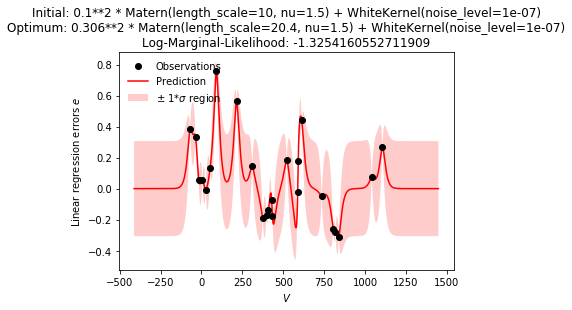

In [19]:
###############################################
#Fit Gaussian Process to residuals
###############################################

#initial guesses for kernel parameter
C_scale = 0.01
M_scale = 10.0
WK_scale = 1e-7

#set up the kernel 
kernel = C(C_scale , (1e-3, 1e3)) * Matern(length_scale=M_scale, length_scale_bounds=(1e-3, 1e3), nu=1.5) \
            + WhiteKernel(noise_level=WK_scale, noise_level_bounds=(1e-10, 1e+1))

#fit the Gaussian process
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(V.reshape(-1,1), e)

#define a V-space grid based on which the GP predictions will be made
x = np.linspace(start=min(V)-np.std(V),stop = max(V)+np.std(V), num = 1000)

#calculate the GP predictions on the V-space grid
e_pred, sigma = gp.predict(x.reshape(-1,1), return_std=True)

#plot residual fit
plt.figure()
plt.plot(V, e, 'ko', zorder=10, label='Observations')
plt.plot(x, e_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([e_pred - 1.0 * sigma,
                        (e_pred + 1.0 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='$\pm$ 1*$\sigma$ region')
plt.xlabel("$V$")
plt.ylabel("Linear regression errors $e$")
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.legend(loc='upper left', frameon=False);
plt.show()

The resulting predictions taking the linear model and the residuals predictions into account is given by

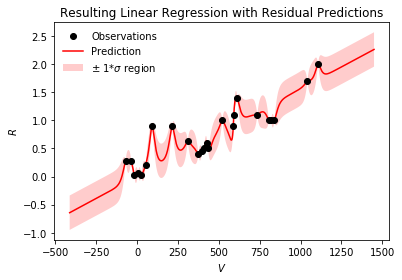

In [20]:
plt.figure()
plt.plot(V, R, 'ko', zorder=10, label='Observations')
plt.plot(x, b*x + e_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([b*x + e_pred - 1.0 * sigma,
                        (b*x+e_pred + 1.0 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='$\pm$ 1*$\sigma$ region')
plt.legend(loc='upper left', frameon=False);
plt.xlabel("$V$")
plt.ylabel("$R$")
plt.title("Resulting Linear Regression with Residual Predictions")
plt.show()

We can also incorporate the estimate for the errors, $e$, as uncertainties in the measured $R(V)$ against a more informed linear regression:

In [21]:
from scipy.optimize import curve_fit

pred_errors = gp.predict(e.reshape(-1,1))

def fn(x, b):
    return x*b
# take predicted errors and add them to a diagonal covariance matrix
sigma_matrix = np.diag(np.squeeze(pred_errors**2))

# re-fit the curve_fit module using the covariances
b_mle,covm = curve_fit(fn, V, R, sigma=sigma_matrix)

In [29]:
print(b_mle, b)

[0.00155408] 0.0015621020061833638


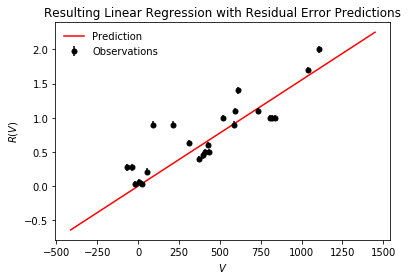

In [26]:
# fit linear regression model using the computed errors
plt.figure()
plt.errorbar(V, R, yerr=pred_errors, fmt='ko', markersize=5, zorder=10, label='Observations')
plt.plot(x, b_mle*x, 'r-', label='Prediction')
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate([b_mle*x + e_pred - 1.0 * sigma,
#                         (b_mle*x+e_pred + 1.0 * sigma)[::-1]]),
#                  alpha=.2, fc='r', ec='None', label='$\pm$ 1*$\sigma$ region')
plt.legend(loc='upper left', frameon=False);
plt.xlabel("$V$")
plt.ylabel("$R(V)$")
plt.title("Resulting Linear Regression with Residual Error Predictions")
plt.show()

### Problem 1.3 (3pts): 

The linear regression errors $e$ from 1.2 appear locally clustered. These correlations of the errors can be accounted for by the GP, but so far the linear regression does not "know" of this new modeling flexibility. Let's find a way to optimize the linear model *and* the GP simultaneously.

The likelihood for the data $\lbrace(x_1,y_1),\dots,(x_N,y_N)\rbrace$ is

$$
\begin{align}
\ln p(\lbrace y_i\rbrace|\lbrace x_i \rbrace, b, \theta) &= -\frac{1}{2} e^\top K_\theta^{-1} e - \frac{1}{2}\ln|K_\theta | - \frac{N}{2}\ln(2\pi)\\
&= -\frac{1}{2}(y - b x)^\top K_\theta^{-1} (y - b x)- \frac{1}{2}\ln|K_\theta | - \frac{N}{2}\ln(2\pi)
\end{align}
$$

where $K_\theta=\kappa(x,x^\top|\theta)$ is the error covariance matrix, and $\theta$ denotes the parameter vector of the kernel function. In other words, $K$ is the covariance matrix of the $e_i$, whose parameters we seek to determine while also determining $b$ through minimizing the $e_i$.

For this to be meaningful we need to specify $\kappa$. The deviations from the mean appear locally clustered, which suggest a distance-based kernel. Like above, we'll use the robust Matérn 3/2 kernel:

$$
\kappa(x,x' | \alpha, \tau) = \alpha^2 \left(1+\frac{\sqrt{3} d}{\tau}\right)\exp\left(-\frac{\sqrt{3} d}{\tau}\right)
$$

where $d=\lVert x-x'\rVert_2$. To account for some (unknown) constant noise level, the data covariance matrix $K$ contains a diagonal term $\sigma_y^2\mathbb{I}$ with the unknown noise variance $\sigma_y^2$ (that's what the `WhiteKernel` above does):

$$
K_\theta \rightarrow K_y \equiv \sigma_y^2\mathbb{I} + \kappa(x,x^\top | \alpha, \tau)
$$

Implement the kernel function and the log likelihood above. Instead of a grid search, compute the gradients wrt the parameters $b$, $\sigma_y$, $\alpha$, and $\tau$ with `jax.grad`. Evaluate the gradients at $(b=0.0015, \sigma_y=0.1, \alpha=1, \tau=100)$. 

**Hints:**  

* `import jax.numpy as np`
* If you cannot install `jax`, try [`autograd`](https://github.com/HIPS/autograd) (its predecessor, installable with `pip install autograd`). Its `grad` function works just the same, but there's no built-in just-in-time compilation.

In [30]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [31]:
###############################################################################
#Problem 1.3
###############################################################################

import jax.numpy as np
from jax import grad

def k(x_0, x_1, alpha, tau):
    return alpha**2 *(1+np.sqrt(3)*np.linalg.norm(x_0-x_1)/tau)*np.exp(-np.sqrt(3)*np.linalg.norm(x_0-x_1)/tau)

def negloglikelihood(param):
    b, sg_y, alpha, tau = param
    km = np.vectorize(lambda x_0,x_1: k(x_0,x_1,alpha,tau))(V[:,None], V)+sg_y**2 * np.identity(len(R))
    return (np.dot( 0.5*(R-b*V), np.linalg.solve(km, R-b*V))+0.5*np.log(np.linalg.det(km)))

grad_negloglike = grad(negloglikelihood)
print('Gradients: ', [round(float(_),4) for _ in grad_negloglike([0.0015, 0.1, 1.0, 100.0])])


Gradients:  [-395.2869, 28.3595, 14.7657, -0.0891]


### Problem 1.4 (2pt):
    
Use the gradient function from 1.3 to perform first-order gradient descent. Choose suitable step sizes and parameter initializations. 

**Hints**: 

* Make sure that all parameters stay positive.
* If needed, terminate the optimization when the value of the loss function increases.

### Problem 1.4 Solution

In [32]:
from jax import jit
import tqdm
from tqdm import tqdm_notebook

First we plot the negative log-likelihood, varying only one parameter at a time. From these plots, we can select good initialisations and appropriate step sizes for the optimisation process.

In [33]:
# Compute the negative log-likelihood at a grid of values, varying one parameter at a time

b_0, sgY_0, alpha_0, tau_0 = 0.0015, 0.1, 1.0, 100.0

x_b = np.linspace(1e-5, 1e-2, 100)
y_b = []
for i in tqdm_notebook(range(len(x_b)), 'b'):
    y_b.append(negloglikelihood([x_b[i], sgY_0, alpha_0, tau_0]))
    
x_sgY = np.linspace(1e-5, 1, 100)
y_sgY = []
for i in tqdm_notebook(range(len(x_sgY)), 'sgY'):
    y_sgY.append(negloglikelihood([b_0, x_sgY[i], alpha_0, tau_0]))

x_alpha = np.linspace(1e-5, 2, 100)
y_alpha = []
for i in tqdm_notebook(range(len(x_alpha)), 'alpha'):
    y_alpha.append(negloglikelihood([b_0, sgY_0, x_alpha[i], tau_0]))
    
x_tau = np.linspace(1, 1000, 100)
y_tau = []
for i in tqdm_notebook(range(len(x_tau)), 'tau'):
    y_tau.append(negloglikelihood([b_0, sgY_0, alpha_0, x_tau[i]]))


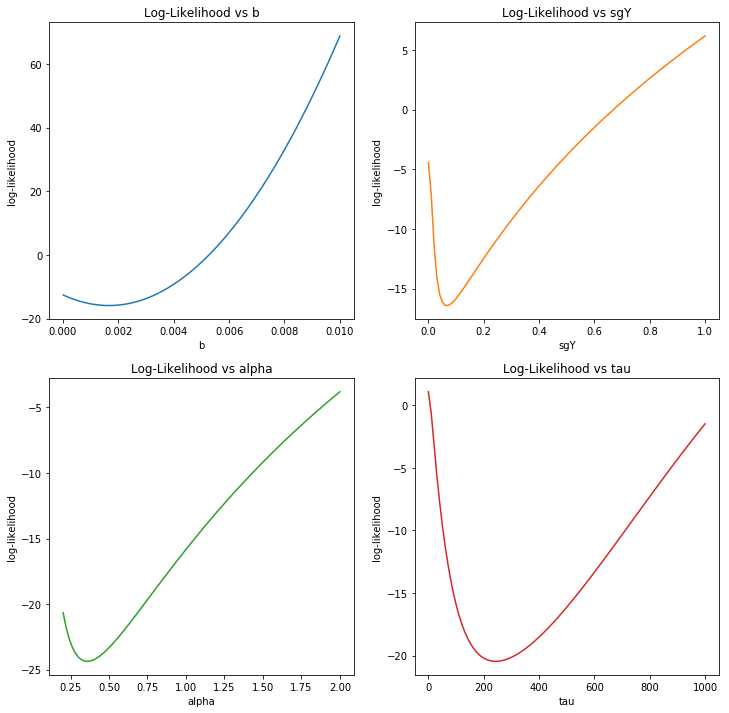

In [34]:
# Plot the negative log-likelihood vs each parameter

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].plot(x_b, np.asarray(y_b))
axs[0,0].set_title('Log-Likelihood vs b')
axs[0,0].set_xlabel('b')

axs[0,1].plot(x_sgY, np.asarray(y_sgY), 'tab:orange')
axs[0,1].set_title('Log-Likelihood vs sgY')
axs[0,1].set_xlabel('sgY')

axs[1,0].plot(x_alpha, np.asarray(y_alpha), 'tab:green')
axs[1,0].set_title('Log-Likelihood vs alpha')
axs[1,0].set_xlabel('alpha')

axs[1,1].plot(x_tau, np.asarray(y_tau), 'tab:red')
axs[1,1].set_title('Log-Likelihood vs tau')
axs[1,1].set_xlabel('tau')

for ax in axs.flat:
    ax.set(ylabel='log-likelihood')

fig.show()

From the plots, we see that the minima appear to be achieved at approximately $ b = 0.00175 $, $ \sigma_Y = 0.075 $, $ \alpha = 0.35 $, and $ \tau = 220 $. Thus, we choose values that are near to these as our initialisations.


Next, we define functions for our optimisation process.

In [35]:
@jit
def update(params, step_sizes):
    grads = grad_negloglike(params)
    return tuple(x - step_size * dx for x, dx, step_size in zip(params, grads, step_sizes))

# @jit
def optimize(params, step_sizes, steps=100):
    losses = [1e15]
    for step in tqdm_notebook(range(steps)):
        loss = negloglikelihood(params)
        if loss > losses[-1]:
            return params, losses
        else:
            losses.append(loss)
            params = update(params, step_sizes)
    return params, losses


Then, we use the update function to compute the actual changes in the parameters based on the gradient of our negative log-likelihood function and the step sizes. We use this to select our set of step sizes.

In [36]:
# Initialisation
params_test = [0.002, 0.1, 0.5, 200.0]
step_sizes_test = [1e-7, 1e-3, 1e-3, 1e-1]
param_names = ['b', 'sg_Y', 'alpha', 'tau']
grads_test = [round(float(_),4) for _ in grad_negloglike(params_test)]
new_params_test = [round(float(_),4) for _ in update(params_test, step_sizes_test)]
diffs_test = np.asarray(params_test) - np.asarray(new_params_test)

print('Parameters: ', param_names)
print('Gradients: ', grads_test)
print('Initial Parameters: ', params_test)
print('New Parameters', new_params_test)
print('Difference: ', diffs_test)

Parameters:  ['b', 'sg_Y', 'alpha', 'tau']
Gradients:  [2172.2314, -42.0288, -5.4194, 0.0308]
Initial Parameters:  [0.002, 0.1, 0.5, 200.0]
New Parameters [0.0018, 0.142, 0.5054, 199.9969]
Difference:  [ 0.0002     -0.042      -0.0054      0.00309753]


We note that the changes in the parameteres seem reasonable given our expected minima values. Finally, we perform the gradient descent optimisation.

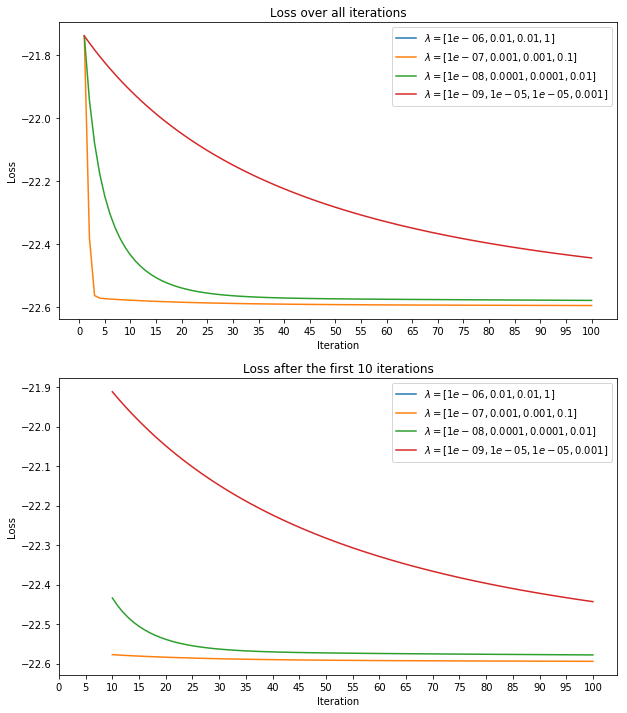

In [37]:
# Initialisation
params_0 = [0.002, 0.1, 0.5, 200.0]
step_sizes_list = [[1e-6, 1e-2, 1e-2, 1],     # one order higher than set tested
                   [1e-7, 1e-3, 1e-3, 1e-1],  # set tested
                   [1e-8, 1e-4, 1e-4, 1e-2],  # one order lower than set tested
                   [1e-9, 1e-5, 1e-5, 1e-3]]  # two orders lower than set tested

fig, axs = plt.subplots(2, 1, figsize=(10,12))
plot2_min_iter = 10
params_list = []
losses_list = []

for step_sizes in step_sizes_list:
    params, losses = optimize(params_0, step_sizes, steps=100)
    params_list.append(params)
    losses_list.append(losses)
    axs[0].plot(range(1,len(losses)), 
                  losses[1:], 
                  label='$\lambda={}$'.format(step_sizes))
    axs[1].plot(range(plot2_min_iter,len(losses)), 
                  losses[plot2_min_iter:], 
                  label='$\lambda={}$'.format(step_sizes))

for i in range(2):
    axs[i].legend();
    axs[i].set_xlabel('Iteration');
    axs[i].set_xticks(range(0,len(losses),5))
    axs[i].set_ylabel('Loss');

axs[0].set_title('Loss over all iterations')
axs[1].set_title('Loss after the first {} iterations'.format(plot2_min_iter))
    
fig.show()

We see that the first set of step sizes are too large (blue) and the loss actually increases at the first step (see first progress bar), so the process stops. All of the other sets of step sizes work, but the second set clearly decreases fastest.

In order to better see how the different step sizes affect the optimisation process, we also plot the curves after 10 iterations (helps narrow in on the y-axis).

### Problem 1.5 (1pt):

Visualize the result:

1. Plot the matrix $K_\theta$ for the data with the parameters $\tilde\theta$ you have determined in 1.4.
2. Plot the data, the prediction mean and the $\pm1\sigma$ confidence regions. For that, compute $e = y - \tilde{b} x$, compute the mean $\mu_*$ and covariance $\Sigma_*$ of the GP for $e$. Note that the cross-covariance $K_{X*}$ does not contain a diagonal error term. The final prediction is then $\tilde{y} = \tilde{b} x + \mu_* \pm \mathrm{Diag}\left(\Sigma_*^{1/2}\right)$.

In [38]:
# get parameters from gradient descent 
import numpy as onp
opt_params = onp.array(params_list[len(params_list)-1])

b_opt = opt_params[0]
sg_y_opt = opt_params[1]
alpha_opt = opt_params[2]
tau_opt = opt_params[3]

print('b:', b_opt)
print('sigma:', sg_y_opt)
print('alpha:', alpha_opt)
print('tau:', tau_opt)

b: 0.0018400357
sigma: 0.118829615
alpha: 0.50210536
tau: 199.99786


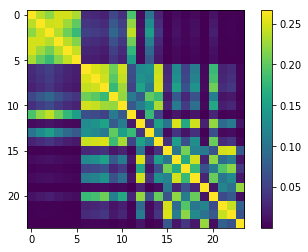

In [39]:
# compute K_theta with new parameters from gradient descent [need to rename kernel function]
km = np.vectorize(lambda x_0,x_1: k(x_0,x_1,alpha_opt,tau_opt))(V[:,None], V)+sg_y_opt**2 * np.identity(len(R))

plt.imshow(km)
plt.colorbar()
plt.show()

In [40]:
import scipy

#fit the Gaussian process
e = R - b_opt*V
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(V.reshape(-1,1), e)

#define a V-space grid based on which the GP predictions will be made
x = np.linspace(start=min(V)-np.std(V),stop = max(V)+np.std(V), num = 1000)

#calculate the GP predictions on the V-space grid
mu_star, sigma_star = gp.predict(x.reshape(-1,1), return_cov=True) # now getting a covariance matrix (return_cov)

# calculate final prediction [R~] and uncertainty [diag(Sigma*^{1/2})]
R_pred = b_opt*x + mu_star
uncertainty = np.diag(scipy.linalg.sqrtm(sigma_star))

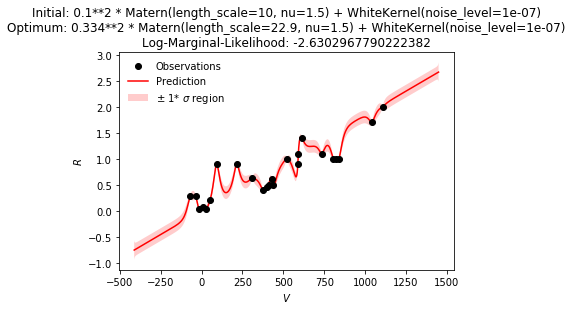

In [41]:
#plot 
plt.figure()
plt.plot(V, R, 'ko', zorder=10, label='Observations')
plt.plot(x, R_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([R_pred - 1.0 * uncertainty,
                        (R_pred + 1.0 * uncertainty)[::-1]]),
         alpha=.2, fc='r', ec='None', label='$ \pm$ 1* $\sigma$ region')
plt.xlabel("$V$")
plt.ylabel("$R$")
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
            % (kernel, gp.kernel_,
               gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.legend(loc='upper left', frameon=False);
plt.show()